<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Ejercicios/03-Agrupamiento-Jerarquico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Facultad de Ciencias Exactas, Naturales y Ambientales</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Agrupamiento Jerarquico
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Andrés Merino &bull; 2025-04
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

A lo largo de este taller, aplicaremos el algoritmo de agrupamiento jerárquico a un conjunto de datos.

Los paquetes necesarios son:

In [1]:
# Paquetes necesarios
import pandas as pd # Para manejo de datos
import matplotlib.pyplot as plt # Para visualización
import numpy as np # Para manejo de arreglos
import plotly.express as px # Para visualización
from scipy.spatial.distance import cdist # Para cálculo de distancias
# Modelo de clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Estandarización de datos
from sklearn.preprocessing import StandardScaler
# Para PCA
from sklearn.decomposition import PCA
#Para método silueta
from sklearn.metrics import silhouette_score, silhouette_samples

import gdown

---
## <font color='264CC7'> Preprocesamiento de datos </font>

Primero necesitas el conjunto de datos. Los datos a utilzar son los seleccionados en la clase aterior.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Carga el conjunto de datos y procésalos:
<ul>
  <li>Muestra algunos datos.</li>
  <li>Muestra una descripción de los datos.</li>
  <li>Escala los datos si es necesario.</li>
</ul>
</div>

1.  Cargar el conjunto de datos

In [2]:
url = "https://drive.google.com/uc?id=1zBu79031KDxexYedgjMUyAi1ixEn-5sY"
output = "nanotox_dataset.csv"

gdown.download(url, output, quiet=False)

# Cargamos el dataset
df = pd.read_csv(output)

print("Dimensión del dataset:", df.shape)
print("\nColumnas:")
print(df.columns.tolist())



Downloading...
From: https://drive.google.com/uc?id=1zBu79031KDxexYedgjMUyAi1ixEn-5sY
To: c:\Users\ignaz\OneDrive\Desktop\Quinto semestre\apendizaje automatico\AprendizajeAutomatico\nanotox_dataset.csv
100%|██████████| 44.1k/44.1k [00:00<00:00, 911kB/s]

Dimensión del dataset: (881, 11)

Columnas:
['NPs', 'coresize', 'hydrosize', 'surfcharge', 'surfarea', 'Ec', 'Expotime', 'dosage', 'e', 'NOxygen', 'class']


Analisis rápido

In [3]:
# Tipos y nulos
print("\nINFO:")
print(df.info())

print("\nNulos por columna:")
print(df.isna().sum().sort_values(ascending=False))

# Duplicados
print("\nDuplicados:", df.duplicated().sum())

# Revisión de valores únicos en variables clave
for col in ["NPs", "class"]:
    if col in df.columns:
        print(f"\nValores únicos en {col} (top 20):")
        display(df[col].value_counts().head(20))

# Estadísticos descriptivos solo numéricos
num_df = df.select_dtypes(include=[np.number])
print("\nResumen numérico (describe):")
display(num_df.describe().T)

# Intento de detectar columnas numéricas guardadas como texto
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("\nColumnas tipo object:", obj_cols)




INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NPs         881 non-null    object 
 1   coresize    881 non-null    float64
 2   hydrosize   881 non-null    float64
 3   surfcharge  881 non-null    float64
 4   surfarea    881 non-null    float64
 5   Ec          881 non-null    float64
 6   Expotime    881 non-null    int64  
 7   dosage      881 non-null    float64
 8   e           881 non-null    float64
 9   NOxygen     881 non-null    int64  
 10  class       881 non-null    object 
dtypes: float64(7), int64(2), object(2)
memory usage: 75.8+ KB
None

Nulos por columna:
NPs           0
coresize      0
hydrosize     0
surfcharge    0
surfarea      0
Ec            0
Expotime      0
dosage        0
e             0
NOxygen       0
class         0
dtype: int64

Duplicados: 487

Valores únicos en NPs (top 20):


NPs
ZnO      594
TiO2     200
CuO       51
Al2O3     18
Fe2O3     18
Name: count, dtype: int64


Valores únicos en class (top 20):


class
Toxic       476
nonToxic    405
Name: count, dtype: int64


Resumen numérico (describe):


,count,mean,std,min,25%,50%,75%,max
coresize,881.0,56.313280,33.700297,7.50000,32.00,45.30,86.00,125.00
hydrosize,881.0,513.781385,346.601373,74.00000,273.40,327.00,687.00,1843.00
surfcharge,881.0,1.642111,25.635780,-41.60000,-11.70,-9.30,29.40,42.80
surfarea,881.0,42.074075,47.111739,7.00000,15.00,24.10,42.50,210.00
Ec,881.0,-4.018127,0.509806,-5.17000,-4.16,-3.89,-3.89,-1.51
Expotime,881.0,27.459705,19.534667,3.00000,12.00,24.00,24.00,72.00
dosage,881.0,39.651270,38.163289,0.00001,10.00,25.00,50.00,300.00
e,881.0,1.646050,0.089304,1.54000,1.65,1.65,1.65,1.90
NOxygen,881.0,1.308740,0.543581,1.00000,1.00,1.00,2.00,3.00



Columnas tipo object: ['NPs', 'class']


2. Mostrar Datos

In [4]:


print("\nPrimeras filas del dataset:")
display(df.head())

print("\nDescripción estadística (variables numéricas):")
display(df.describe())



Primeras filas del dataset:


,NPs,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class
0,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,0.001,1.61,3,nonToxic
1,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,0.010,1.61,3,nonToxic
2,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,0.100,1.61,3,nonToxic
3,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,1.000,1.61,3,nonToxic
4,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,5.000,1.61,3,nonToxic



Descripción estadística (variables numéricas):


,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,56.313280,513.781385,1.642111,42.074075,-4.018127,27.459705,39.651270,1.646050,1.308740
std,33.700297,346.601373,25.635780,47.111739,0.509806,19.534667,38.163289,0.089304,0.543581
min,7.500000,74.000000,-41.600000,7.000000,-5.170000,3.000000,0.000010,1.540000,1.000000
25%,32.000000,273.400000,-11.700000,15.000000,-4.160000,12.000000,10.000000,1.650000,1.000000
50%,45.300000,327.000000,-9.300000,24.100000,-3.890000,24.000000,25.000000,1.650000,1.000000
75%,86.000000,687.000000,29.400000,42.500000,-3.890000,24.000000,50.000000,1.650000,2.000000
max,125.000000,1843.000000,42.800000,210.000000,-1.510000,72.000000,300.000000,1.900000,3.000000


3. Escalamiento de los datos

In [5]:
# Seleccionamos SOLO variables numéricas (excluimos 'class' y 'NPs')
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("\nColumnas numéricas utilizadas para clustering:")
print(num_cols)

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])

# Convertimos a DataFrame para mejor lectura
df_scaled = pd.DataFrame(X_scaled, columns=num_cols)

print("\nPrimeras filas de los datos escalados:")
display(df_scaled.head())



Columnas numéricas utilizadas para clustering:
['coresize', 'hydrosize', 'surfcharge', 'surfarea', 'Ec', 'Expotime', 'dosage', 'e', 'NOxygen']

Primeras filas de los datos escalados:


,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen
0,-0.493251,-0.712408,1.352702,0.480534,4.922563,-0.177207,-1.039554,-0.403904,3.113097
1,-0.493251,-0.712408,1.352702,0.480534,4.922563,-0.177207,-1.039318,-0.403904,3.113097
2,-0.493251,-0.712408,1.352702,0.480534,4.922563,-0.177207,-1.036958,-0.403904,3.113097
3,-0.493251,-0.712408,1.352702,0.480534,4.922563,-0.177207,-1.013362,-0.403904,3.113097
4,-0.493251,-0.712408,1.352702,0.480534,4.922563,-0.177207,-0.908490,-0.403904,3.113097


---
## <font color='264CC7'> Dendograma </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Genera el dendograma de los datos.
<ul>
  <li>Usa diferentes métricas y funciones de enlace.</li>
  <li>Toma una distancia de corte.</li>
  <li>De manera intutiva, ¿por qué tomaste la métrica y la distancia de corte?</li>
</ul>
</div>

1. Distancia Euclidiana + Enlace Ward

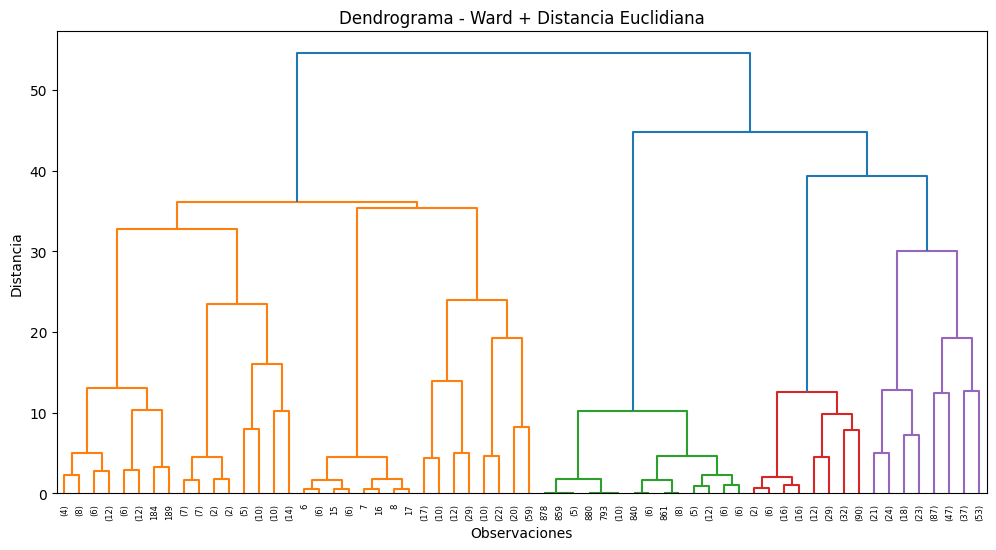

In [6]:
Z_ward = linkage(df_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z_ward, truncate_mode='level', p=5)
plt.title("Dendrograma - Ward + Distancia Euclidiana")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

2. Enlace completo (complete linkage)

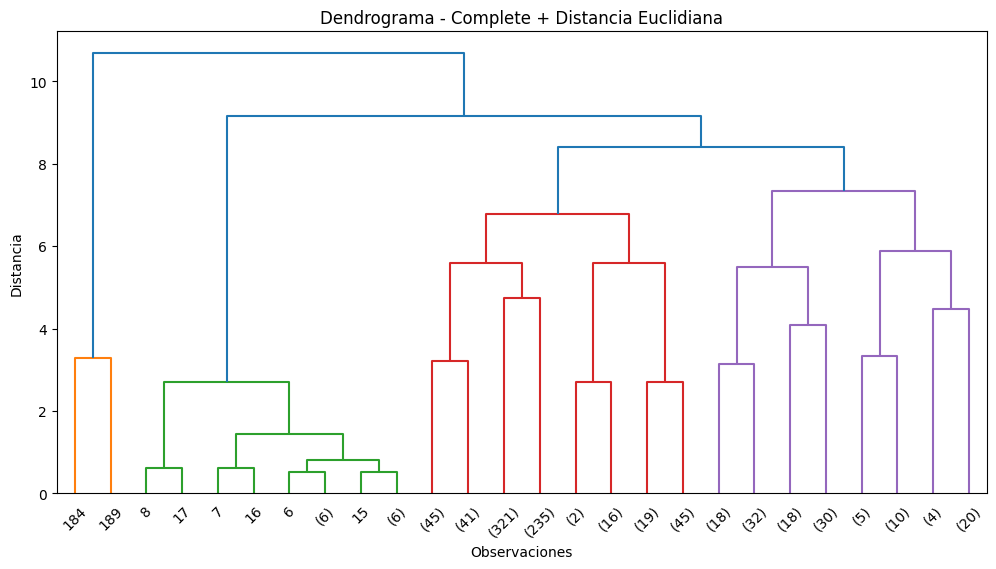

In [7]:
Z_complete = linkage(df_scaled, method='complete', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(Z_complete, truncate_mode='level', p=5)
plt.title("Dendrograma - Complete + Distancia Euclidiana")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()


3. Distancia Manhattan + enlace average

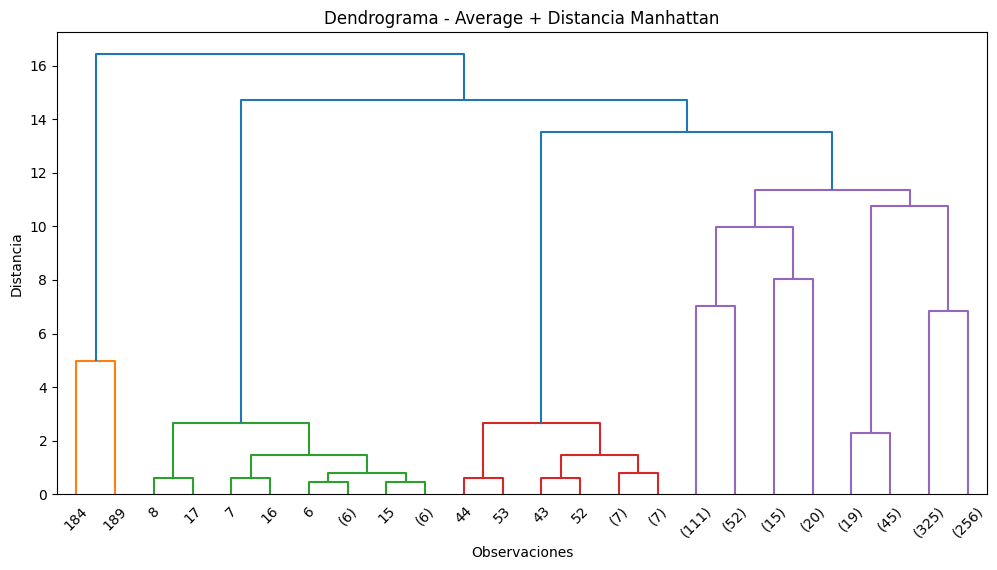

In [8]:
Z_average_manhattan = linkage(
    df_scaled,
    method='average',
    metric='cityblock'
)

plt.figure(figsize=(12, 6))
dendrogram(Z_average_manhattan, truncate_mode='level', p=5)
plt.title("Dendrograma - Average + Distancia Manhattan")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()


4. Dendrograma completo - Ward

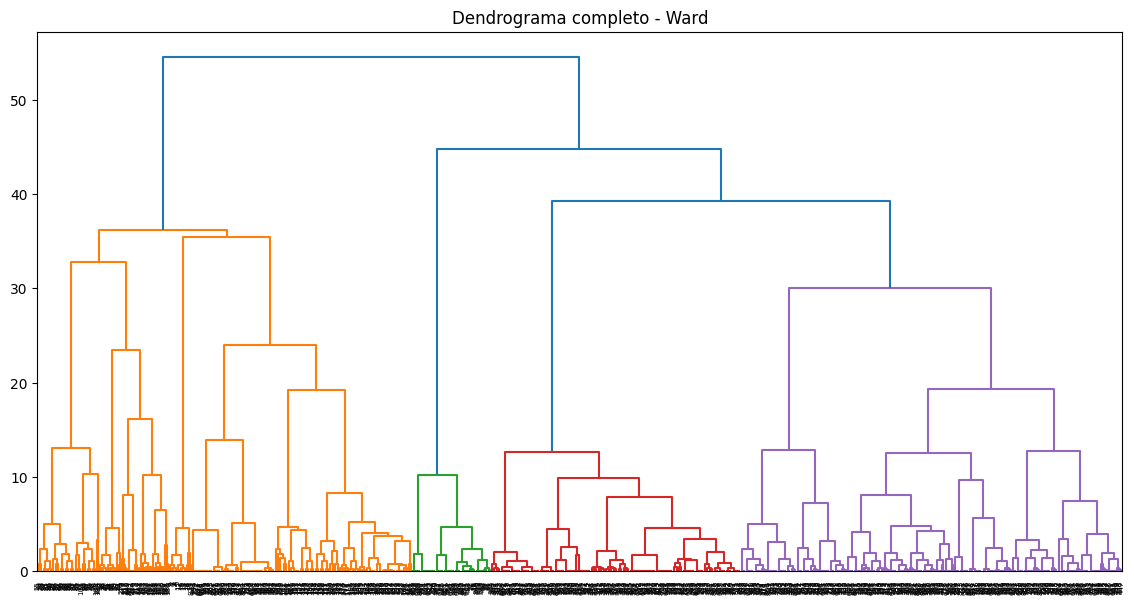

In [9]:
plt.figure(figsize=(14, 7))
dendrogram(Z_ward)
plt.title("Dendrograma completo - Ward")
plt.show()


5. Corte del dendrograma

In [10]:
from scipy.cluster.hierarchy import fcluster


cut_distance = 40

clusters = fcluster(Z_ward, t=cut_distance, criterion='distance')

print("Número de clusters obtenidos:", len(set(clusters)))


Número de clusters obtenidos: 3


Se utilizó la distancia euclidiana con el método Ward porque los datos son numéricos y estandarizados, y este método forma clusters compactos y homogéneos. La distancia de corte se eligió observando el mayor salto en el dendrograma, ya que indica la unión de grupos muy diferentes. De esta forma se conservan clusters bien definidos y representativos de la estructura natural de los datos.

---
## <font color='264CC7'> Asignación de grupos y análisis </font>


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza un análisis de los grupos obtenidos.
<ul>
  <li>Asigna los grupos.</li>
  <li>Revisa la media de cada grupo.</li>
  <li>Revisa el mínimo y máximo de cada grupo.</li>
  <li>Muestra algunos integrantes de cada grupo.</li>
</ul>
</div>

1. Asignación de grupos

In [11]:
cut_distance = 40

clusters = fcluster(Z_ward, t=cut_distance, criterion='distance')


df_clusters = df.copy()
df_clusters["cluster"] = clusters

print("Número de clusters obtenidos:", df_clusters["cluster"].nunique())
df_clusters["cluster"].value_counts().sort_index()

Número de clusters obtenidos: 3


cluster
1    304
2     64
3    513
Name: count, dtype: int64

2. Media de cada grupo

In [12]:
cluster_means = df_clusters.groupby("cluster")[num_cols].mean()

print("Media de cada grupo:")
display(cluster_means)

Media de cada grupo:


,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen
cluster,,,,,,,,,
1,35.561513,508.536184,-19.563158,73.725987,-3.991842,23.723684,46.380080,1.585921,1.894737
2,46.300000,239.000000,42.800000,24.100000,-5.170000,18.750000,47.065969,1.900000,1.000000
3,69.859844,551.170370,9.073489,25.559766,-3.890000,30.760234,34.738796,1.650000,1.000000


3. Mínimo y máximo de cada grupo

In [13]:
# Mínimos por cluster
cluster_min = df_clusters.groupby("cluster")[num_cols].min()

# Máximos por cluster
cluster_max = df_clusters.groupby("cluster")[num_cols].max()

print("Mínimos por grupo:")
display(cluster_min)

print("Máximos por grupo:")
display(cluster_max)

Mínimos por grupo:


,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen
cluster,,,,,,,,,
1,10.0,74.0,-41.6,27.9,-4.99,3,0.00001,1.54,1
2,46.3,239.0,42.8,24.1,-5.17,12,0.00100,1.90,1
3,7.5,273.4,-11.7,7.0,-3.89,3,0.00001,1.65,1


Máximos por grupo:


,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen
cluster,,,,,,,,,
1,125.0,1843.0,36.3,210.0,-1.51,72,300.0,1.83,3
2,46.3,239.0,42.8,24.1,-5.17,24,100.0,1.90,1
3,115.0,1093.0,32.7,90.0,-3.89,72,100.0,1.65,1


4. Mostrar algunos integrantes de cada grupo

In [14]:
for c in sorted(df_clusters["cluster"].unique()):
    print(f"\nCluster {c} (primeras 5 observaciones):")
    display(
        df_clusters[df_clusters["cluster"] == c]
        .head(5)
    )


Cluster 1 (primeras 5 observaciones):


,NPs,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class,cluster
0,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,0.001,1.61,3,nonToxic,1
1,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,0.010,1.61,3,nonToxic,1
2,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,0.100,1.61,3,nonToxic,1
3,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,1.000,1.61,3,nonToxic,1
4,Al2O3,39.7,267.0,36.3,64.7,-1.51,24,5.000,1.61,3,nonToxic,1



Cluster 2 (primeras 5 observaciones):


,NPs,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class,cluster
18,CuO,46.3,239.0,42.8,24.1,-5.17,24,0.001,1.9,1,nonToxic,2
19,CuO,46.3,239.0,42.8,24.1,-5.17,24,0.010,1.9,1,nonToxic,2
20,CuO,46.3,239.0,42.8,24.1,-5.17,24,0.100,1.9,1,nonToxic,2
21,CuO,46.3,239.0,42.8,24.1,-5.17,24,1.000,1.9,1,nonToxic,2
22,CuO,46.3,239.0,42.8,24.1,-5.17,24,5.000,1.9,1,nonToxic,2



Cluster 3 (primeras 5 observaciones):


,NPs,coresize,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class,cluster
249,ZnO,45.3,310.0,32.7,21.3,-3.89,24,0.001,1.65,1,nonToxic,3
250,ZnO,45.3,310.0,32.7,21.3,-3.89,24,0.010,1.65,1,nonToxic,3
251,ZnO,45.3,310.0,32.7,21.3,-3.89,24,0.100,1.65,1,nonToxic,3
252,ZnO,45.3,310.0,32.7,21.3,-3.89,24,1.000,1.65,1,nonToxic,3
253,ZnO,45.3,310.0,32.7,21.3,-3.89,24,5.000,1.65,1,nonToxic,3


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Da una descripción de los grupos obtenidos. Asigna un nombre a cada grupo.
</div>

**Cluster 1** – Nanopartículas de alta superficie y carga negativa

(304 observaciones)

Este grupo se caracteriza por nanopartículas con tamaños de núcleo relativamente pequeños, superficie elevada y carga superficial predominantemente negativa. Presenta una gran variabilidad en hidrosize, área superficial y dosis, lo que indica condiciones experimentales diversas. El número de átomos de oxígeno es mayor en promedio, lo que sugiere estructuras químicas más complejas.

Nombre asignado: NPs de alta superficie y carga negativa

**Cluster 2** – Nanopartículas altamente cargadas y homogéneas

(64 observaciones)

Este grupo es el más compacto y homogéneo, con valores prácticamente constantes en tamaño, carga superficial positiva alta y energía. Corresponde principalmente a un tipo específico de nanopartícula bajo condiciones controladas. La baja variabilidad indica un perfil fisicoquímico muy definido.

Nombre asignado: NPs altamente cargadas y homogéneas

**Cluster 3** – Nanopartículas de mayor tamaño y carga moderada

(513 observaciones)

Este grupo agrupa nanopartículas con mayor tamaño promedio, carga superficial positiva moderada y menor área superficial en comparación con el Cluster 1. Presenta mayor tiempo de exposición promedio y una variabilidad intermedia, lo que sugiere condiciones experimentales más estables pero diversas.

Nombre asignado: NPs de mayor tamaño y carga moderada

---
## <font color='264CC7'> Visualizaciones  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza una visualización de los grupos obtenidos en 2D.
<ul>
  <li>¿Qué tan buenos te parecen los grupos?</li>
  <li>Indica el porcentaje de la variaza explicada en el gráfico, ¿afecta esto a tu visualización?</li>
</ul>
</div>

PCA a 2 dimensiones

In [15]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)


df_pca = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)


df_pca["cluster"] = df_clusters["cluster"]


Porcentaje de varianza explicada

In [16]:
explained_variance = pca.explained_variance_ratio_ * 100

print("Varianza explicada por PC1: {:.2f}%".format(explained_variance[0]))
print("Varianza explicada por PC2: {:.2f}%".format(explained_variance[1]))
print("Varianza total explicada (2D): {:.2f}%".format(explained_variance.sum()))


Varianza explicada por PC1: 26.16%
Varianza explicada por PC2: 18.08%
Varianza total explicada (2D): 44.24%


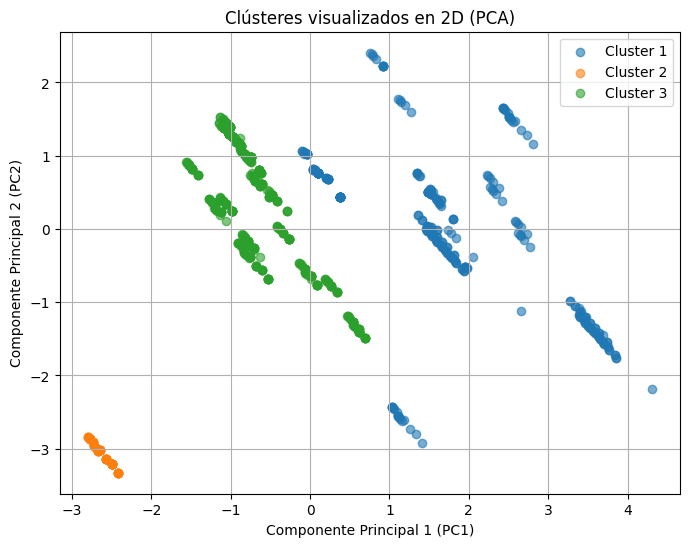

In [17]:
plt.figure(figsize=(8, 6))

for c in sorted(df_pca["cluster"].unique()):
    subset = df_pca[df_pca["cluster"] == c]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        label=f"Cluster {c}",
        alpha=0.6
    )

plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.title("Clústeres visualizados en 2D (PCA)")
plt.legend()
plt.grid(True)
plt.show()


Mediante PCA en 2D se visualizan adecuadamente los tres clusters, observándose una separación clara, especialmente del Cluster 2. Los grupos parecen coherentes, aunque existe cierto solapamiento entre algunos de ellos. Las dos primeras componentes explican el 44.24% de la varianza, lo que afecta parcialmente la visualización, pero permite identificar la estructura general de los datos.

---
## <font color='264CC7'> Métricas  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Calcula la métrica de la silueta para los grupos obtenidos. ¿Qué tan buenos te parecen los grupos?
</div>

In [18]:
X = df_scaled.values
labels = df_clusters["cluster"].values

# Silueta promedio
silhouette_avg = silhouette_score(X, labels, metric="euclidean")

print("Coeficiente de silueta promedio:", round(silhouette_avg, 4))

Coeficiente de silueta promedio: 0.3001


El coeficiente de silueta promedio obtenido es 0.30, lo que indica que los clusters presentan una estructura aceptable pero no fuertemente separada.  En general, los clusters pueden considerarse razonables para un análisis exploratorio, pero no óptimos.

---
## <font color='264CC7'> Iteraciones </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza el proceso de agrupamiento jerárquico con diferentes parámetros, analiza la métrica de la silueta de cada uno e indica cuál es el mejor.
</div>

In [19]:
# Datos
X = df_scaled.values

# Configuraciones a probar
configs = [
    ("Ward", "ward", "euclidean"),
    ("Complete", "complete", "euclidean"),
    ("Average_Euclidean", "average", "euclidean"),
    ("Average_Manhattan", "average", "cityblock"),
]

results = []

cut_distance = 40  # Mismo criterio de corte

for name, method, metric in configs:
    if method == "ward":
        Z = linkage(X, method=method)
    else:
        Z = linkage(X, method=method, metric=metric)

    labels = fcluster(Z, t=cut_distance, criterion="distance")

    # Solo calculamos silueta si hay más de 1 cluster
    if len(set(labels)) > 1:
        sil = silhouette_score(X, labels, metric="euclidean")
    else:
        sil = np.nan

    results.append({
        "Método": name,
        "Clusters": len(set(labels)),
        "Silueta promedio": round(sil, 4)
    })

# Resultados en tabla
df_results = pd.DataFrame(results)
display(df_results)

,Método,Clusters,Silueta promedio
0,Ward,3,0.3001
1,Complete,1,NaN
2,Average_Euclidean,1,NaN
3,Average_Manhattan,1,NaN


In [20]:
# Datos
X = df_scaled.values

# Configuraciones a probar
configs = [
    ("Ward", "ward", "euclidean"),
    ("Complete", "complete", "euclidean"),
    ("Average_Euclidean", "average", "euclidean"),
    ("Average_Manhattan", "average", "cityblock"),
]

results = []

cut_distance = 10  # Cambio criterio de corte

for name, method, metric in configs:
    if method == "ward":
        Z = linkage(X, method=method)
    else:
        Z = linkage(X, method=method, metric=metric)

    labels = fcluster(Z, t=cut_distance, criterion="distance")

    # Solo calculamos silueta si hay más de 1 cluster
    if len(set(labels)) > 1:
        sil = silhouette_score(X, labels, metric="euclidean")
    else:
        sil = np.nan

    results.append({
        "Método": name,
        "Clusters": len(set(labels)),
        "Silueta promedio": round(sil, 4)
    })

# Resultados en tabla
df_results = pd.DataFrame(results)
display(df_results)

,Método,Clusters,Silueta promedio
0,Ward,22,0.5112
1,Complete,2,0.5121
2,Average_Euclidean,1,NaN
3,Average_Manhattan,6,0.3747


Al evaluar distintas configuraciones, el mejor desempeño según la métrica de la silueta se obtuvo con el método complete y distancia euclidiana usando un criterio de corte de 10, alcanzando un valor cercano a 0.51. Esto indica clusters bien separados. No obstante, el método Ward con un corte mayor ofrece una solución más interpretable, aunque con menor calidad de separación.